# Forecasting Defaults in the FNMA Single Family Loan Dataset

# Using Minority Oversampling, Support Vector Machines and Comparison to Logistic Regression

# Feature Importance/Attribution Using SHAPLEY Values

We will use Support Vector Machines with a Linear Kernel to build a model to predict defaults for loans issued in 2007. We will use over-sampling  of the minority class to account for the fact that defaults are a very small part of the data set.

We will compare this to the Logistic Regression Model we built earlier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC # Supprt Vector Classifier


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.metrics import roc_curve, precision_recall_curve

from sklearn.metrics import roc_auc_score, auc


import datetime as datetime

import shap as shap
shap.initjs()

In [2]:
processed_file_nameQ1 = '2007Q1_BaseTable7'
processed_file_nameQ2 = '2007Q2_BaseTable7'
processed_file_nameQ3 = '2007Q3_BaseTable7'
processed_file_nameQ4 = '2007Q4_BaseTable7'

In [3]:
parse_date_cols = ['ORIG_DTE', 'FRST_DTE','LAST_ACTIVITY_DATE', 'LPI_DTE', 'FCC_DTE', 'DISP_DTE', 
                   'F30_DTE', 'F60_DTE', 'F90_DTE', 'F120_DTE', 'F180_DTE','FCE_DTE','FMOD_DTE','LAST_DTE']


df_fnma_dataQ1 = pd.read_csv(processed_file_nameQ1, dtype={'zip_3':'object'}, parse_dates=parse_date_cols)
df_fnma_dataQ2 = pd.read_csv(processed_file_nameQ2, dtype={'zip_3':'object'}, parse_dates=parse_date_cols)
df_fnma_dataQ3 = pd.read_csv(processed_file_nameQ3, dtype={'zip_3':'object'}, parse_dates=parse_date_cols)
df_fnma_dataQ4 = pd.read_csv(processed_file_nameQ4, dtype={'zip_3':'object'}, parse_dates=parse_date_cols)

In [4]:
df_fnma_data= pd.concat([df_fnma_dataQ1,df_fnma_dataQ2,df_fnma_dataQ3,df_fnma_dataQ4], ignore_index= True)

## Using Fannie Mae's definition of a defaulted Loan, where Loan is Third Party Sale or Short Sale or Deed-in-Lieu or Notes Sales

In [5]:
df_fnma_data['DEFAULT'] = np.where(df_fnma_data['COMPLT_FLG']==1,1,0)

## The data is severely imbalanced, with the number of defaults only 8.7 % of Total Loans

In [6]:
print("Percentage of Defaults = {0:.1f}".format(100*df_fnma_data['DEFAULT'].sum()/len(df_fnma_data)))

Percentage of Defaults = 8.7


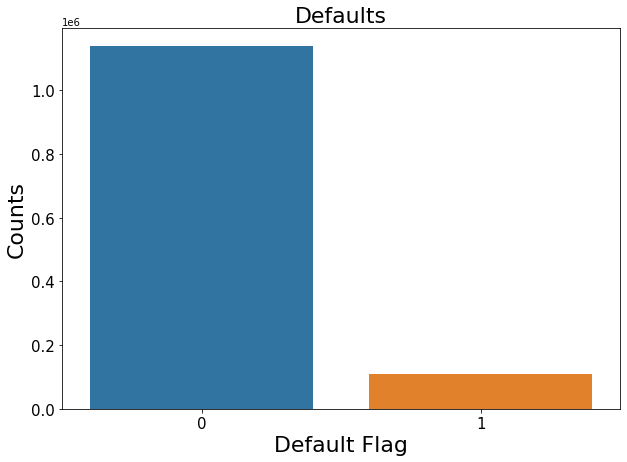

In [7]:
fig = plt.figure(figsize = (10,7))
barplt = sns.countplot(x= 'DEFAULT', data = df_fnma_data,linewidth=2)
barplt.set_xlabel('Default Flag', fontsize = 22)
barplt.set_ylabel('Counts', fontsize = 22)
barplt.set_title('Defaults', fontsize = 22)
barplt.tick_params(labelsize = 15)

#### Discarding loans which are less than 3 months old. Bucketing Credit Scores into FICO score buckets

In [8]:
df_fnma_data['AGE']=(df_fnma_data['LAST_DTE']-df_fnma_data['ORIG_DTE'])/np.timedelta64(1,'M')
df_fnma_data = df_fnma_data.drop(df_fnma_data[df_fnma_data['AGE']<3].index)


list_fico_buckets = [0,580,670,740,800,1000]


df_fnma_data['CSCORE_MN_Buckets'] = pd.cut(df_fnma_data['CSCORE_MN'],list_fico_buckets)
df_fnma_data['CSCORE_B_Buckets'] = pd.cut(df_fnma_data['CSCORE_B'],list_fico_buckets)


In [9]:
df_fnma_data.head()

,Unnamed: 0,LOAN_ID,ORIG_CHN,SELLER,orig_rt,orig_amt,orig_trm,oltv,ocltv,num_bo,...,COMPLT_FLG,INT_COST,PFG_COST,NET_LOSS,NET_SEV,MODTOT_COST,DEFAULT,AGE,CSCORE_MN_Buckets,CSCORE_B_Buckets
0,0,100001461640,R,"Pnc Bank, N.A.",6.250,137000.0,360.0,56.0,56.0,2.0,...,1.0,10505.133496,0.0,1260.143496,0.009743,1751.383969,1,85.948377,"(670, 740]","(740, 800]"
1,1,100015135004,R,Suntrust Mortgage Inc.,6.000,116000.0,360.0,80.0,80.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,36.928890,"(740, 800]","(740, 800]"
2,2,100015306566,C,"Citimortgage, Inc.",6.375,58000.0,180.0,78.0,78.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,67.976755,"(670, 740]","(670, 740]"
3,3,100015319835,C,"Bank Of America, N.A.",6.125,353000.0,360.0,80.0,80.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,11.992033,"(580, 670]","(740, 800]"
4,4,100030521552,C,"Gmac Mortgage, Llc",5.875,385000.0,360.0,70.0,70.0,2.0,...,NaN,NaN,NaN,NaN,NaN,74025.434079,0,110.983798,"(670, 740]","(670, 740]"


## Description of Variables

'''

num_bo = number of borrowers
ocltv = all outstanding loans (heloc etc) divided by value of property

FTHB_FLG : first time home buyer flag, Y if first time, N otherwise

purpose : cash out refi : C, refi : R, purchase : P, refi unspecified : U

prop_type : SF : single family, CO : condo, CP: coop, PU : planned Urban dev, MH : manufactured home

occ_stat : P : principal, S : second, I : investor, U : unknown

CSCORE_MN : min credit score of borrower and co borrower

ORIG_VAL = orig_amount/oltv

LAST_STAT = F - deed in lieu, reo, S - short sale, T - Thirdparty sale , R - repurchased, N - notes sales, 
L - reperforming loan sale , P - prepaid or matured , C - 0 months delinq , 1 - one month delinq, etc 2, 3, 4, 5, 6 , 7, 8

01 = Prepaid or Matured
02 =  Third Party Sale
03 = Short Sale
06 = Repurchased
09 = Deed-in-Lieu; REO Disposition
15 = Notes Sales
16 = Reperforming Loan Sale
96 = Removal (non-credit event)

COMPLT_FLG : 
    COMPLT_FLG = if_else(DISP_DTE != '', 1, 0),
    COMPLT_FLG = if_else(LAST_STAT != 'F' & LAST_STAT != 'S' & LAST_STAT != 'N' & LAST_STAT != 'T', NA_real_, COMPLT_FLG),
    
    
'''



## Choosing Predictor Variables based on Domain Knowledge

I am selectively picking variables which I think can explain defaults. I have chosen to drop variables such as state and issuer. This is because the explanatory nature of these variables on defaults are probably coincidental.

In [10]:
list_pred_columns =['ORIG_CHN','orig_rt','ocltv', 'dti','CSCORE_MN_Buckets','FTHB_FLG','purpose',
                     'occ_stat','LAST_RT','AGE','ORIG_VAL']


In [11]:
df_data_for_pred = df_fnma_data[list_pred_columns+['DEFAULT']]

In [12]:
df_data_for_pred.head()

,ORIG_CHN,orig_rt,ocltv,dti,CSCORE_MN_Buckets,FTHB_FLG,purpose,occ_stat,LAST_RT,AGE,ORIG_VAL,DEFAULT
0,R,6.250,56.0,37.0,"(670, 740]",N,C,P,5.000,85.948377,244642.857143,1
1,R,6.000,80.0,11.0,"(740, 800]",N,R,S,6.000,36.928890,145000.000000,0
2,C,6.375,78.0,30.0,"(670, 740]",N,R,P,6.375,67.976755,74358.974359,0
3,C,6.125,80.0,28.0,"(580, 670]",N,R,P,6.125,11.992033,441250.000000,0
4,C,5.875,70.0,50.0,"(670, 740]",N,C,P,3.000,110.983798,550000.000000,0


In [13]:
df_data_for_pred.dtypes

ORIG_CHN               object
orig_rt               float64
ocltv                 float64
dti                   float64
CSCORE_MN_Buckets    category
FTHB_FLG               object
purpose                object
occ_stat               object
LAST_RT               float64
AGE                   float64
ORIG_VAL              float64
DEFAULT                 int64
dtype: object

In [14]:
allcols = df_data_for_pred.drop('DEFAULT', axis=1).columns
numcols = df_data_for_pred.drop('DEFAULT', axis=1).select_dtypes(include='number').columns
catcols = df_data_for_pred.select_dtypes(include=['object','category']).columns

## Checking for missing data in original data set

We can fill in the missing data in the categorical columns using the most frequent value. For the numerical columns, we are going to use __Sklearn Impute__.

In [15]:
df_data_for_pred.isna().sum()

ORIG_CHN                 0
orig_rt                  1
ocltv                    0
dti                  34147
CSCORE_MN_Buckets     2324
FTHB_FLG               850
purpose                  0
occ_stat                 0
LAST_RT                  5
AGE                      0
ORIG_VAL                 0
DEFAULT                  0
dtype: int64

In [16]:
df_data_for_pred.dtypes

ORIG_CHN               object
orig_rt               float64
ocltv                 float64
dti                   float64
CSCORE_MN_Buckets    category
FTHB_FLG               object
purpose                object
occ_stat               object
LAST_RT               float64
AGE                   float64
ORIG_VAL              float64
DEFAULT                 int64
dtype: object

## SVM Classification OverSampling

### Creating pre-processing pipelines to fill missing data and scale/encode data

In [17]:
 
num_transformer = Pipeline([('imputer', SimpleImputer(strategy = 'mean')), 
                         ('std_scaler', StandardScaler())])

num_transformer = Pipeline([('imputer', SimpleImputer(strategy = 'mean')), 
                         ('std_scaler', StandardScaler())])


cat_transformer = Pipeline([('imputer',SimpleImputer(strategy="most_frequent")),
                         ('onehotencoder',OneHotEncoder(handle_unknown='ignore'))])



preproc_pipeline  = ColumnTransformer(transformers = [('num', num_transformer, list(numcols)),
                                                     ('cat', cat_transformer, list(catcols))])




### We will try a naive random over sampling strategy using the Imbalance Learn Package

In [18]:
from imblearn.over_sampling import RandomOverSampler

X = df_data_for_pred.drop(['DEFAULT'], axis = 1)
y = df_data_for_pred['DEFAULT']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)



### Train/Test split the re sampled data

In [19]:
X_train,X_test, y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = 0.2, random_state = 101)
X_train,X_val, y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2, random_state = 101)

### Defining the SVM  Model

In [20]:
## Capping the number of iterations to speed up the process. We have >1MM points and this can be 
## challenging to fit using an SVM model

## Using the Linear SVC model in Sklearn which is faster than the regular SVC implementation

svcmodel =  LinearSVC(C=1, max_iter = 1000)
pipe_full  = Pipeline(steps=[('preproc_pipeline',preproc_pipeline),('svcmodel',svcmodel)])

### Fitting the SVM Model With Random Oversampling of minority class

In [21]:
start_time = datetime.datetime.now()


pipe_full.fit(X_train,y_train)

time_elapsed = datetime.datetime.now()-start_time

time_elapsed


y_test_pred  = pipe_full.predict(X_test)
y_train_pred = pipe_full.predict(X_train)

Liblinear failed to converge, increase the number of iterations.


### Classification Report on the Test Data

              precision    recall  f1-score   support

           0       0.70      0.64      0.67    226975
           1       0.67      0.73      0.70    226771

    accuracy                           0.69    453746
   macro avg       0.69      0.69      0.68    453746
weighted avg       0.69      0.69      0.68    453746



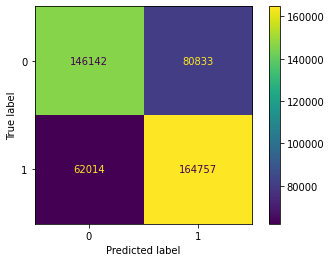

In [22]:
print(classification_report(y_test,y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels = pipe_full.named_steps['svcmodel'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe_full.named_steps['svcmodel'].classes_)
disp.plot()

### ROC Curve and Precision Recall Curve



In [23]:
### Helper Code to plot ROC and Precision Recall Curves

def plot_roc_prc(name, labels, predictions_probs,predictions, **kwargs):
    
    fp, tp, _ = roc_curve(labels, predictions_probs)
    precision, recall, _ = precision_recall_curve(labels, predictions)
    
    print("Area under ROC Curve is {:.2f}".format(roc_auc_score(y_train, y_train_probs)))
    
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,7))
    
    plt.subplot(1,2,1)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2,**kwargs)
    ax1.set_xlabel('False positives [%]', fontsize = 15)
    ax1.set_ylabel('True positives [%]', fontsize = 15)
    ax1.set_xlim([0,100])
    ax1.set_ylim([0,100])
    ax1.tick_params(labelsize = 15)
    ax1.set_title('ROC Curve', fontsize = 15)
    ax1.grid(True)
    ax1.set_aspect('equal')
    
    plt.subplot(1,2,2)
    print("Area under Precision Recall Curve is {:.2f}".format(auc(recall, precision)))
    plt.plot(100*recall, 100*precision, label=name, linewidth=2, **kwargs)
    ax2.set_xlabel('Recall [%]', fontsize = 15)
    ax2.set_ylabel('Precision [%]', fontsize = 15)
    ax2.set_xlim([0,100])
    ax2.set_ylim([0,100])
    ax2.tick_params(labelsize = 15)
    ax2.set_title('Precision Recall Curve', fontsize = 15)
    ax2.grid(True)
    ax2.set_aspect('equal')


    

In [24]:
## The linear SVM classifier has no direct way to calculate probabilities. 
## The Calibrated Classifier in Sklearn helps one do that

from sklearn.calibration import CalibratedClassifierCV
clf_isotonic = CalibratedClassifierCV(base_estimator = pipe_full,cv='prefit',method='isotonic')
clf_isotonic.fit(X_train, y_train)
y_train_probs = clf_isotonic.predict_proba(X_train)[:,1]


The ROC curve is a plot of True Positive Rate vs False Positive Rate. For a random classifier, it should be a 45 degree line through (0,0) and (100,100)

Here, we see that the Support Vector Classifier with a Linear Kernel performs a bit better than a random classifier. However, the performance looks identical the the Logistic Regression Model we fit earlier.


Area under ROC Curve is 0.75
Area under Precision Recall Curve is 0.77


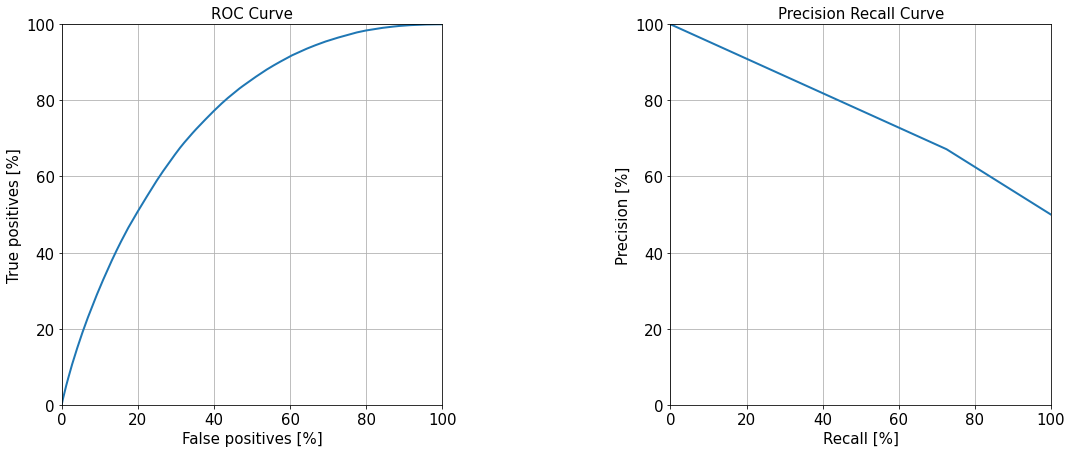

In [25]:
plot_roc_prc("Train", y_train, y_train_probs,y_train_pred)

## We will now use the SHAP package to calculate Shapley values to determine Feature Importance and Explain the model output for a few individual loans

Shapley Value - Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

### Looking at Shapley Values for the Logistic Regression to Determine Feature Importance

In [26]:
cats = list(pipe_full.named_steps['preproc_pipeline'].named_transformers_['cat'][1].get_feature_names_out(input_features=list(catcols)))
nums = list(numcols)
nums.extend(cats)

In [27]:
preproc_pipeline.fit(X_train)
X_train_shap = preproc_pipeline.fit_transform(X_train)
X_test_shap  = preproc_pipeline.transform(X_test)
explainer = shap.Explainer(pipe_full.named_steps['svcmodel'], X_train_shap, feature_perturbation="interventional")
shap_values = explainer(pd.DataFrame(data = X_test_shap, columns = nums))


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


### SHAP Summary Plot

Again, similar to the logistic regression model, the summary plot below is quite intuitive from the perspective of what factors one would expect drives defaults. For example, we can see that high OCLTV and high ORIG_RT lead to a higher SHAP values (higher defaults) and vice versa. 

Similarly, CSCORE_MN_Buckets (740,800] having a high value (meaning a loan with a credit score in this bucket) leads to lower SHAP values (no default). On the other end, CSCORE_MN_Buckets (580,670] having a high value leads to a higher SHAP value indicating a default. Both of these make intuitive sense.

It is also interesting to see that the top 5 important features here are the same as the ones in the logistic regression model

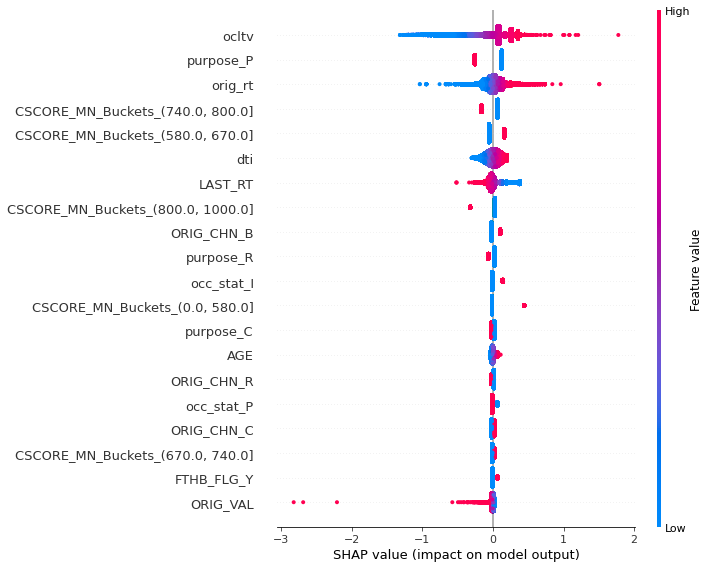

In [28]:
shap.summary_plot(shap_values.values, X_test_shap, feature_names=nums)

### Shap Force Plots and Comparison to Logistic Regression

We are going to use the same loan as the one we used in the Logistic Regression Model. It is good to see that the explanation of the output here is very similar to the one we saw in the Logistic Regression Model.

The average (expected) value across all loans is -0.07. For this example, the predicted value was 0.4. The values in red on the left helped push this predicted value away from the baseline (-0.07) to the right while the variables in blue helped push the predicted value to the left.

In the example below, the biggest contributor in pushing the value away from the base value was OCLTV.

In [29]:
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_shap[0], feature_names=nums)

A shap force plot for another instance. Here, the low orig_rt and ocltv values were the largest contributors in pushing the predicted value away from the average predicted value

In [30]:
shap.force_plot(explainer.expected_value, shap_values.values[100], X_test_shap[100], feature_names=nums)

### SHAP Bar Plots

From the docs - "a default SHAP bar plot is the mean absolute value of each feature over all the instances of the dataset"

### We see that the Original LTV, Original Rate, Credit Scores either High or Low, Debt to Income, and Cash Out Refis being the most important Features

Again, we see that the top 5 features here are the same as the ones in logistic regression.

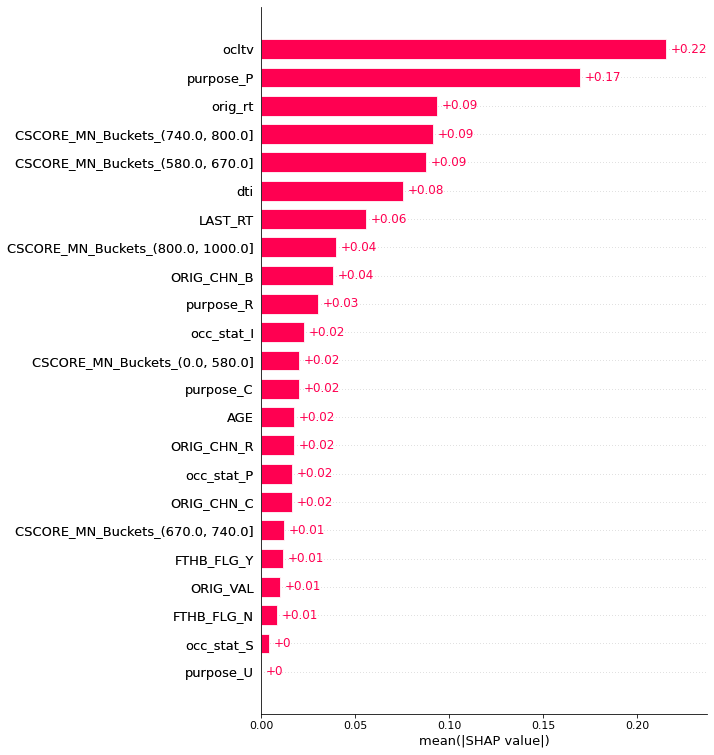

In [31]:
shap.plots.bar(shap_values, max_display=25)

### SHAP Waterfall Depiction For One Loan Sample

From the documentation - "SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained."


The baseline value of the model output is -0.19 (E(f(x)). The value for this particular loan is 2.215. 

In the waterfall plot below, we can see that the OCLTV value of 1.206 (standardized value) contributed to an increase of 0.89 to the SHAP value and so on.

1
ORIG_CHN                      C
orig_rt                   6.125
ocltv                      50.0
dti                        57.0
CSCORE_MN_Buckets    (580, 670]
FTHB_FLG                      N
purpose                       C
occ_stat                      P
LAST_RT                   6.125
AGE                   58.021725
ORIG_VAL               530000.0
Name: 2024931, dtype: object


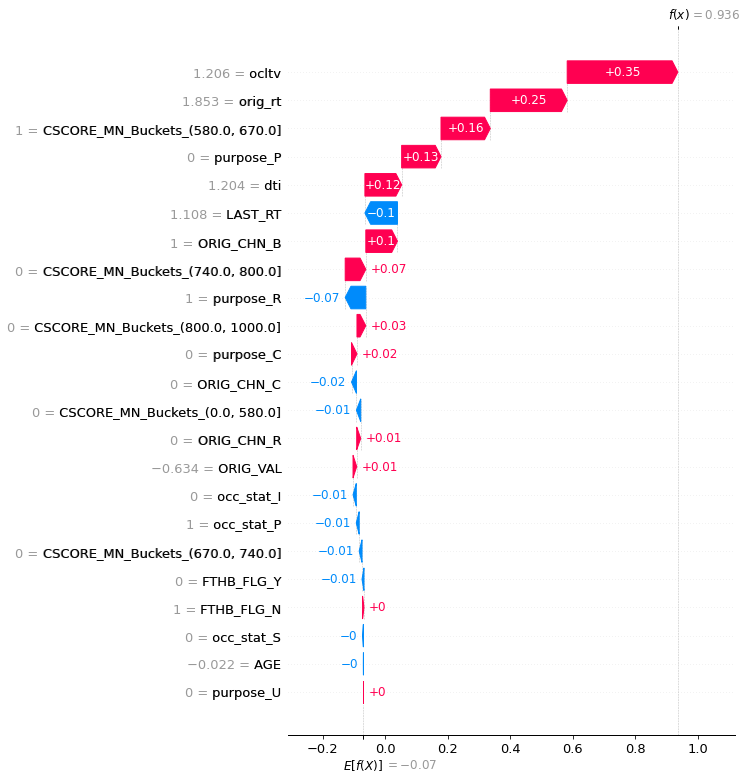

In [32]:
ix=12000
print(y_test.iloc[1000])
print(X_test.iloc[1000,:])
shap.plots.waterfall(shap_values[ix],max_display=25)
